## Lab5: Learning and Testing model

Импортируем библиотеки 

In [91]:
import os
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functional
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
from typing import Tuple, Any

Чтение путей из csv файла

In [144]:
csv_path = "C:/Users/boris/Desktop/unik/python_university_laba/dataset/dataset.csv"
dframe = pd.read_csv(csv_path, delimiter=",", names=["Absolute path", "Relative path", "Class"])
images = dframe["Absolute path"].to_list()
random.shuffle(images)

print(images[0])
print(images[1])
print(images[2])


C:\Users\boris\Desktop\unik\python_university_laba\dataset\rose\0000.jpg
C:\Users\boris\Desktop\unik\python_university_laba\dataset\rose\0001.jpg
C:\Users\boris\Desktop\unik\python_university_laba\dataset\rose\0002.jpg


Разделение данных в отношение 8 : 1 : 1

In [93]:
train_list = images[0:int(len(images) * 0.8)]
test_list = images[int(len(images) * 0.8) : int(len(images) * 0.9)]
valid_list = images[int(len(images) * 0.9) : len(images)]

print(len(train_list), len(test_list), len(valid_list))

1608 201 202


проверка датасета

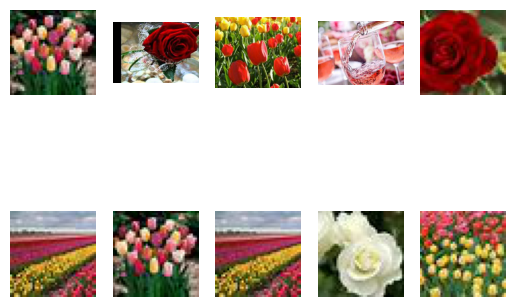

In [94]:
random_idx = np.random.randint(1,len(images),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(images[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')
    
plt.show()


Класс который будет хранить все данные изображенний

In [95]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, images, transform:Any=None) -> None:
        self.dataset = images
        self.transform = transform


    def __len__(self) -> int:
        return len(self.dataset)
    

    def __getitem__(self,index : int) -> Tuple[torch.tensor, int]:
        img_path = self.dataset[index]
        img = Image.open(img_path)
        img = self.transform(img)
        img_label = []
        for i in range(len(self.dataset)):
            img_label.append(os.path.basename(os.path.dirname(self.dataset[i])))
        label = img_label[index]
        if label == "rose":
            label = 0
        elif label == "tulip":
            label = 1
        return img, label
    


Предобработка данных для обучения

In [96]:
custom_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
train_data = dataset(train_list, transform=custom_transforms)
test_data = dataset(test_list, transform=custom_transforms)
valid_data = dataset(valid_list, transform=custom_transforms)

Проверка shape у картинки

In [97]:
train_data[0][0].shape

torch.Size([3, 224, 224])

Делаем модель сверточной нейронной сети для решения задачи классификации:

1. 3 слоя свертки и 2 полностью связанных слоя
2. пакетная нормализация для ограничения переобучения

In [98]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(576,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0),-1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return output
    

In [99]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = CNN()
model.train()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Рисовалка графиков

In [100]:
def draw_results(epochs, acc, loss, v_acc, v_loss) -> None:
    """Creates graphs based on the learning results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), acc, color="green", label="Train accuracy")
    ax2.plot(range(epochs), loss, color="green", label="Train loss")
    ax1.plot(range(epochs), v_acc, color="orange", label="Validation accuracy")
    ax2.plot(range(epochs), v_loss, color="orange", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show()

Цикл обучения модели

In [101]:
def train_loop(epochs, batch_size, lear) -> Tuple[list, CNN]:
    optimizer = optim.Adam(params=model.parameters(), lr=lear)
    criterion = nn.CrossEntropyLoss()

    accuracy_values = []
    loss_values = []
    valid_accuracy_values = []
    valid_loss_values = []
    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_data, batch_size=batch_size, shuffle=False
    )
    train_loader = torch.utils.data.DataLoader(
        dataset=train_data, batch_size=batch_size, shuffle=True
    )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        print(
           f"Epoch : {epoch + 1}, train accuracy : {epoch_accuracy}, train loss : {epoch_loss}"
        )
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            print(
                f"Epoch : {epoch + 1}, val_accuracy : {epoch_val_accuracy}, val_loss : {epoch_val_loss}"
            )
            valid_accuracy_values.append(epoch_val_accuracy.item())
            valid_loss_values.append(epoch_val_loss.item())
    draw_results(epochs, accuracy_values, loss_values, valid_accuracy_values, valid_loss_values)

9 запусков для обучения 

Epoch : 1, train accuracy : 0.7291176319122314, train loss : 0.5434106588363647
Epoch : 1, val_accuracy : 0.5533333420753479, val_loss : 0.6624641418457031
Epoch : 2, train accuracy : 0.8650000691413879, train loss : 0.36139753460884094
Epoch : 2, val_accuracy : 0.753333330154419, val_loss : 0.5870587229728699
Epoch : 3, train accuracy : 0.902353048324585, train loss : 0.282865047454834
Epoch : 3, val_accuracy : 0.5900000333786011, val_loss : 0.5112109184265137
Epoch : 4, train accuracy : 0.9120587706565857, train loss : 0.2369353473186493
Epoch : 4, val_accuracy : 0.6166666746139526, val_loss : 0.6086432933807373
Epoch : 5, train accuracy : 0.9270588755607605, train loss : 0.20525188744068146
Epoch : 5, val_accuracy : 0.6200000047683716, val_loss : 0.49818018078804016
Epoch : 6, train accuracy : 0.9300000071525574, train loss : 0.19269654154777527
Epoch : 6, val_accuracy : 0.6333333253860474, val_loss : 0.7893611192703247
Epoch : 7, train accuracy : 0.9394116997718811, train loss : 0.

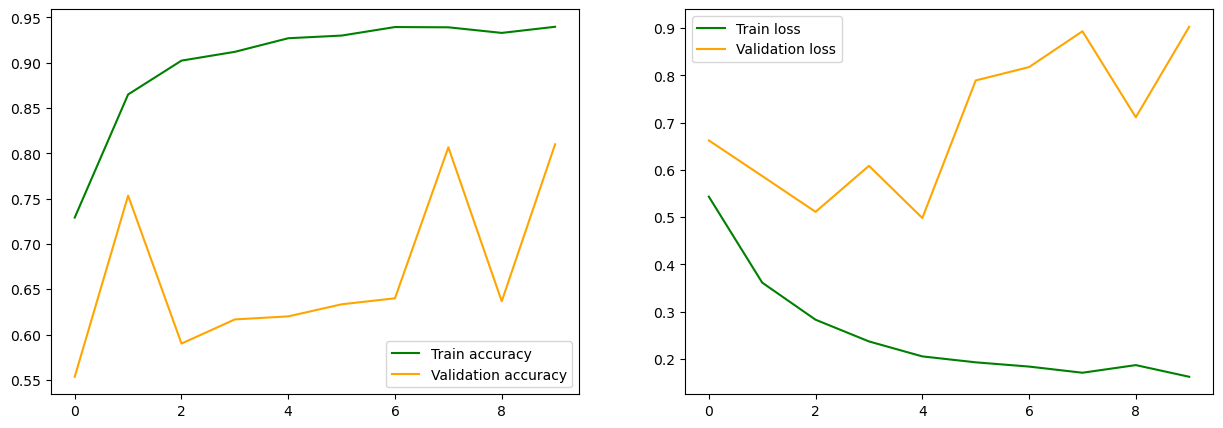

In [102]:
# ephos = 10; batch_size = 100; learning_rate = 0.001
train_loop(10, 100, 0.001)

Epoch : 1, train accuracy : 0.9449999928474426, train loss : 0.16997873783111572
Epoch : 1, val_accuracy : 0.47749999165534973, val_loss : 0.8588423728942871
Epoch : 2, train accuracy : 0.9216666221618652, train loss : 0.1728726625442505
Epoch : 2, val_accuracy : 0.4650000035762787, val_loss : 1.3352177143096924
Epoch : 3, train accuracy : 0.9333332777023315, train loss : 0.15463881194591522
Epoch : 3, val_accuracy : 0.7274999618530273, val_loss : 0.5073376297950745
Epoch : 4, train accuracy : 0.9511111378669739, train loss : 0.1374124139547348
Epoch : 4, val_accuracy : 0.7324999570846558, val_loss : 1.1187411546707153
Epoch : 5, train accuracy : 0.958888828754425, train loss : 0.14261437952518463
Epoch : 5, val_accuracy : 0.48249998688697815, val_loss : 0.7473756074905396
Epoch : 6, train accuracy : 0.9449999332427979, train loss : 0.1369856894016266
Epoch : 6, val_accuracy : 0.7324999570846558, val_loss : 0.5941471457481384
Epoch : 7, train accuracy : 0.9344444274902344, train loss :

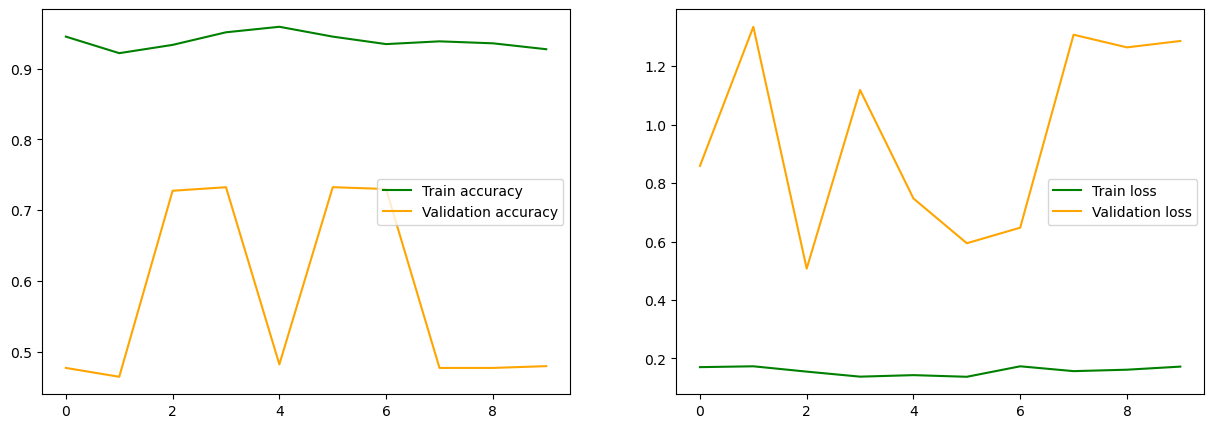

In [103]:
# ephos = 10; batch_size = 200; learning_rate = 0.001
train_loop(10, 200, 0.001)

Epoch : 1, train accuracy : 0.9501851797103882, train loss : 0.1336468905210495
Epoch : 1, val_accuracy : 0.9801980257034302, val_loss : 0.0998847484588623
Epoch : 2, train accuracy : 0.9621605277061462, train loss : 0.11096414178609848
Epoch : 2, val_accuracy : 0.9554455280303955, val_loss : 0.12394661456346512
Epoch : 3, train accuracy : 0.9654937982559204, train loss : 0.09946876764297485
Epoch : 3, val_accuracy : 0.9653465151786804, val_loss : 0.10655143111944199
Epoch : 4, train accuracy : 0.9567283987998962, train loss : 0.10876280814409256
Epoch : 4, val_accuracy : 0.9900990128517151, val_loss : 0.06035410985350609
Epoch : 5, train accuracy : 0.9669135808944702, train loss : 0.0931096225976944
Epoch : 5, val_accuracy : 0.9752475023269653, val_loss : 0.08117932826280594
Epoch : 6, train accuracy : 0.969691276550293, train loss : 0.07819151878356934
Epoch : 6, val_accuracy : 0.9702970385551453, val_loss : 0.09143693745136261
Epoch : 7, train accuracy : 0.9624073505401611, train lo

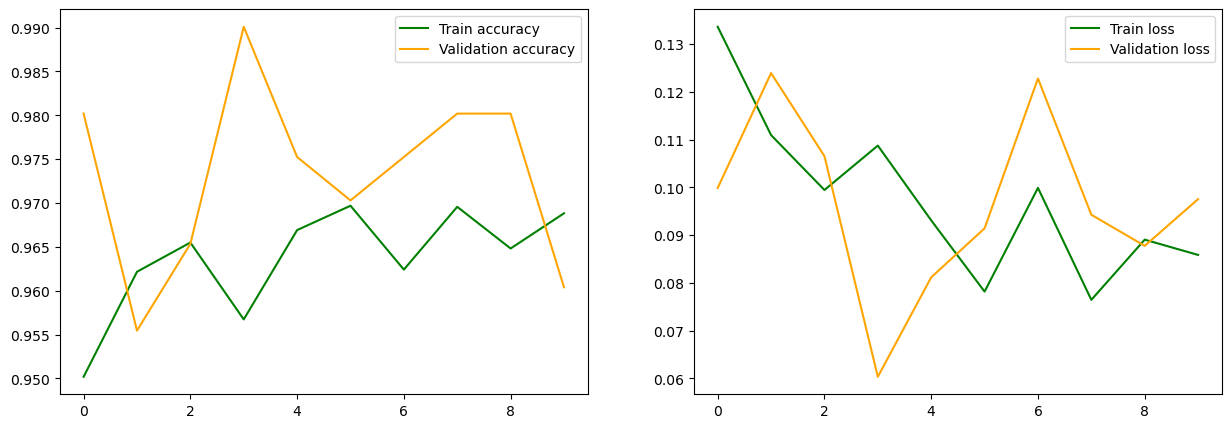

In [104]:
# ephos = 10; batch_size = 300; learning_rate = 0.001
train_loop(10, 300, 0.001)

Epoch : 1, train accuracy : 0.9047059416770935, train loss : 0.2657366693019867
Epoch : 1, val_accuracy : 0.6133333444595337, val_loss : 0.7306118607521057
Epoch : 2, train accuracy : 0.9247058629989624, train loss : 0.18052710592746735
Epoch : 2, val_accuracy : 0.6299999952316284, val_loss : 0.5055348873138428
Epoch : 3, train accuracy : 0.9179412722587585, train loss : 0.18625123798847198
Epoch : 3, val_accuracy : 0.6266666650772095, val_loss : 0.8275999426841736
Epoch : 4, train accuracy : 0.9323528409004211, train loss : 0.1513640284538269
Epoch : 4, val_accuracy : 0.6466667056083679, val_loss : 0.7062808871269226
Epoch : 5, train accuracy : 0.9482351541519165, train loss : 0.12850838899612427
Epoch : 5, val_accuracy : 0.6233333349227905, val_loss : 1.0662493705749512
Epoch : 6, train accuracy : 0.9473528265953064, train loss : 0.12587103247642517
Epoch : 6, val_accuracy : 0.6433333158493042, val_loss : 0.9366978406906128
Epoch : 7, train accuracy : 0.9505881667137146, train loss :

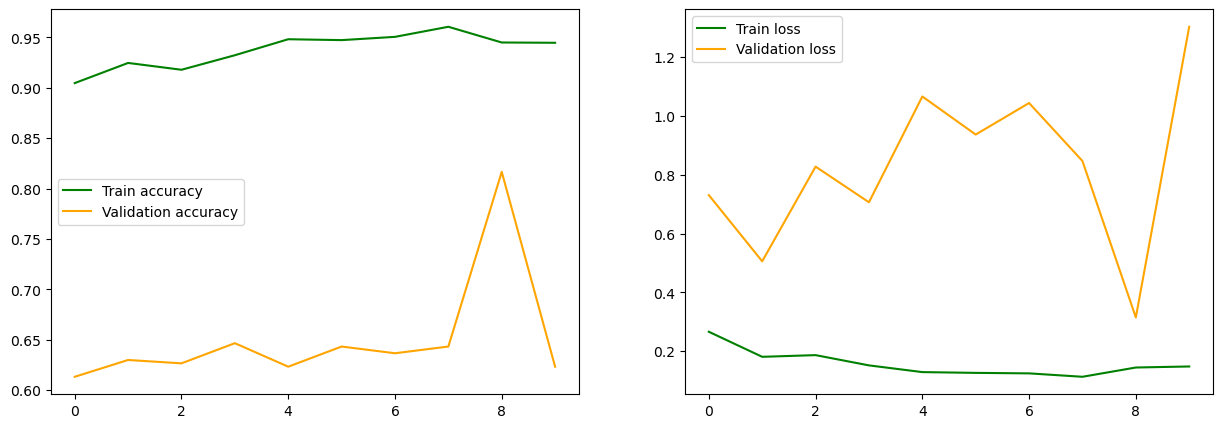

In [105]:
# ephos = 10; batch_size = 100; learning_rate = 0.003
train_loop(10, 100, 0.003)

Epoch : 1, train accuracy : 0.9488888382911682, train loss : 0.14446865022182465
Epoch : 1, val_accuracy : 0.4749999940395355, val_loss : 1.1491034030914307
Epoch : 2, train accuracy : 0.9438889026641846, train loss : 0.14970985054969788
Epoch : 2, val_accuracy : 0.4749999940395355, val_loss : 0.8795278668403625
Epoch : 3, train accuracy : 0.9405555725097656, train loss : 0.17019955813884735
Epoch : 3, val_accuracy : 0.7024999856948853, val_loss : 0.8483850359916687
Epoch : 4, train accuracy : 0.912222146987915, train loss : 0.18811744451522827
Epoch : 4, val_accuracy : 0.4724999964237213, val_loss : 1.4714303016662598
Epoch : 5, train accuracy : 0.9350000023841858, train loss : 0.1638004034757614
Epoch : 5, val_accuracy : 0.9650000333786011, val_loss : 0.22540372610092163
Epoch : 6, train accuracy : 0.9388889074325562, train loss : 0.19445650279521942
Epoch : 6, val_accuracy : 0.4749999940395355, val_loss : 0.8326846361160278
Epoch : 7, train accuracy : 0.9433333277702332, train loss 

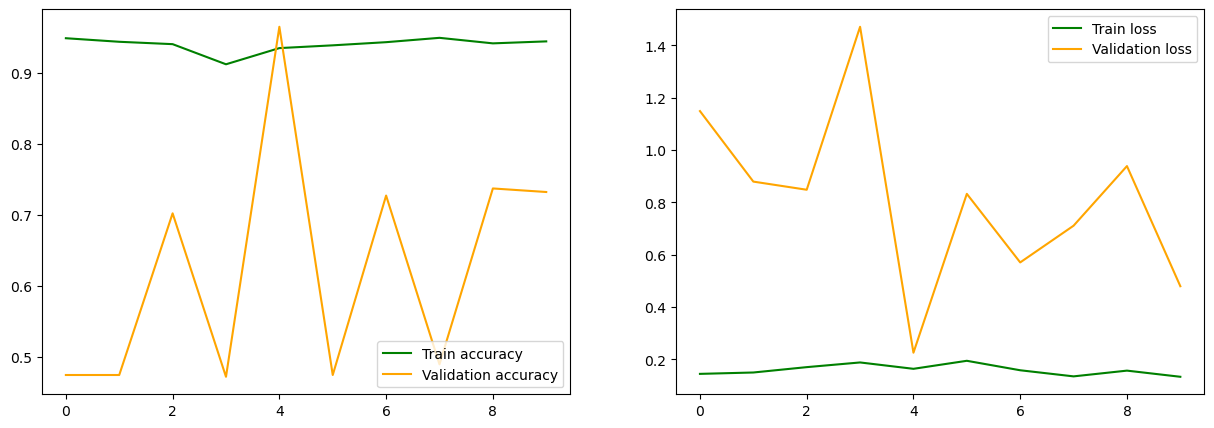

In [106]:
# ephos = 10; batch_size = 200; learning_rate = 0.003
train_loop(10, 200, 0.003)

Epoch : 1, train accuracy : 0.9560494422912598, train loss : 0.12864458560943604
Epoch : 1, val_accuracy : 0.9653465151786804, val_loss : 0.09201940894126892
Epoch : 2, train accuracy : 0.9593827128410339, train loss : 0.11229293793439865
Epoch : 2, val_accuracy : 0.9653465151786804, val_loss : 0.11270642280578613
Epoch : 3, train accuracy : 0.9494444131851196, train loss : 0.13104365766048431
Epoch : 3, val_accuracy : 0.9752475023269653, val_loss : 0.08154527842998505
Epoch : 4, train accuracy : 0.973456859588623, train loss : 0.0770430639386177
Epoch : 4, val_accuracy : 0.9504950642585754, val_loss : 0.14050602912902832
Epoch : 5, train accuracy : 0.963518500328064, train loss : 0.0856182649731636
Epoch : 5, val_accuracy : 0.9801980257034302, val_loss : 0.06522149592638016
Epoch : 6, train accuracy : 0.9698147773742676, train loss : 0.07669372856616974
Epoch : 6, val_accuracy : 0.9851484894752502, val_loss : 0.08318601548671722
Epoch : 7, train accuracy : 0.9711728692054749, train lo

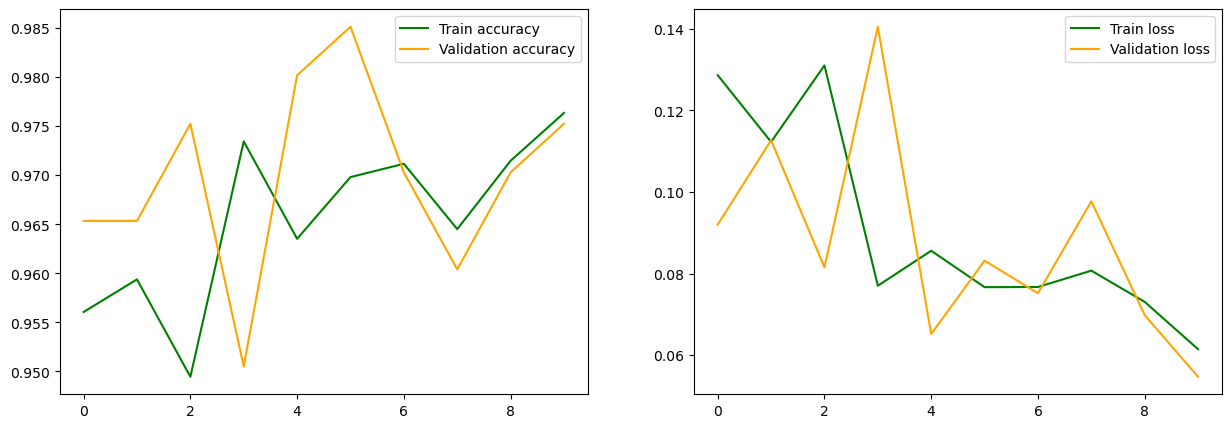

In [107]:
# ephos = 10; batch_size = 300; learning_rate = 0.003
train_loop(10, 300, 0.003)

Epoch : 1, train accuracy : 0.9317646622657776, train loss : 0.18190312385559082
Epoch : 1, val_accuracy : 0.79666668176651, val_loss : 0.44362354278564453
Epoch : 2, train accuracy : 0.9432351589202881, train loss : 0.14179912209510803
Epoch : 2, val_accuracy : 0.800000011920929, val_loss : 0.5118373036384583
Epoch : 3, train accuracy : 0.9435293674468994, train loss : 0.14645424485206604
Epoch : 3, val_accuracy : 0.6233333349227905, val_loss : 0.7989909648895264
Epoch : 4, train accuracy : 0.9444116950035095, train loss : 0.13451865315437317
Epoch : 4, val_accuracy : 0.7933333516120911, val_loss : 0.4458848834037781
Epoch : 5, train accuracy : 0.9349998831748962, train loss : 0.16822238266468048
Epoch : 5, val_accuracy : 0.8133333325386047, val_loss : 0.30563753843307495
Epoch : 6, train accuracy : 0.9264705181121826, train loss : 0.17225128412246704
Epoch : 6, val_accuracy : 0.8133333325386047, val_loss : 1.6229465007781982
Epoch : 7, train accuracy : 0.9297057390213013, train loss 

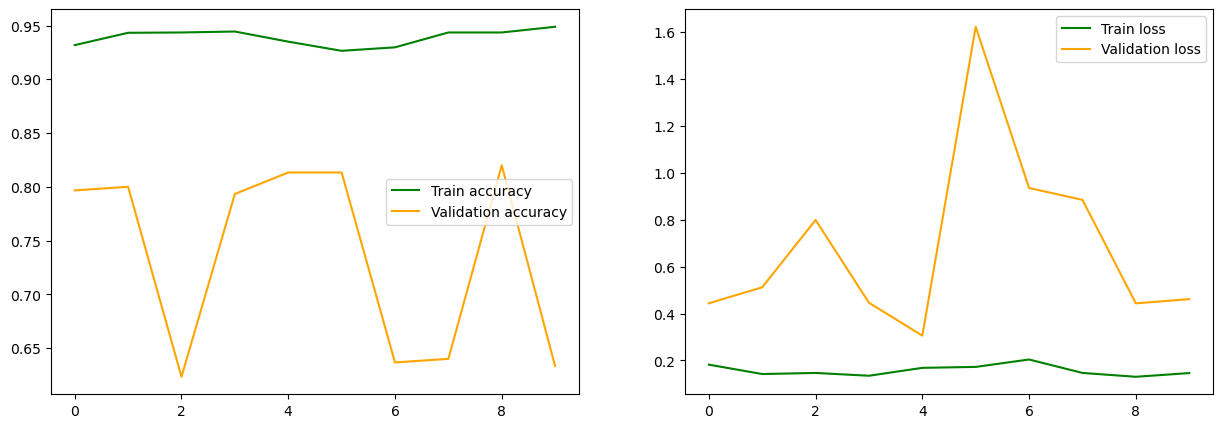

In [108]:
# ephos = 10; batch_size = 100; learning_rate = 0.006
train_loop(10, 100, 0.006)

Epoch : 1, train accuracy : 0.9511111378669739, train loss : 0.14193975925445557
Epoch : 1, val_accuracy : 0.7224999666213989, val_loss : 1.487680196762085
Epoch : 2, train accuracy : 0.9511111378669739, train loss : 0.13980157673358917
Epoch : 2, val_accuracy : 0.7300000190734863, val_loss : 0.5245254635810852
Epoch : 3, train accuracy : 0.9416666030883789, train loss : 0.14023680984973907
Epoch : 3, val_accuracy : 0.7250000238418579, val_loss : 1.351841688156128
Epoch : 4, train accuracy : 0.9444444179534912, train loss : 0.1406128704547882
Epoch : 4, val_accuracy : 0.9650000333786011, val_loss : 0.16022616624832153
Epoch : 5, train accuracy : 0.92166668176651, train loss : 0.20051175355911255
Epoch : 5, val_accuracy : 0.4625000059604645, val_loss : 0.5384624004364014
Epoch : 6, train accuracy : 0.9422222375869751, train loss : 0.14770212769508362
Epoch : 6, val_accuracy : 0.7250000238418579, val_loss : 0.7422228455543518
Epoch : 7, train accuracy : 0.9127777814865112, train loss : 0

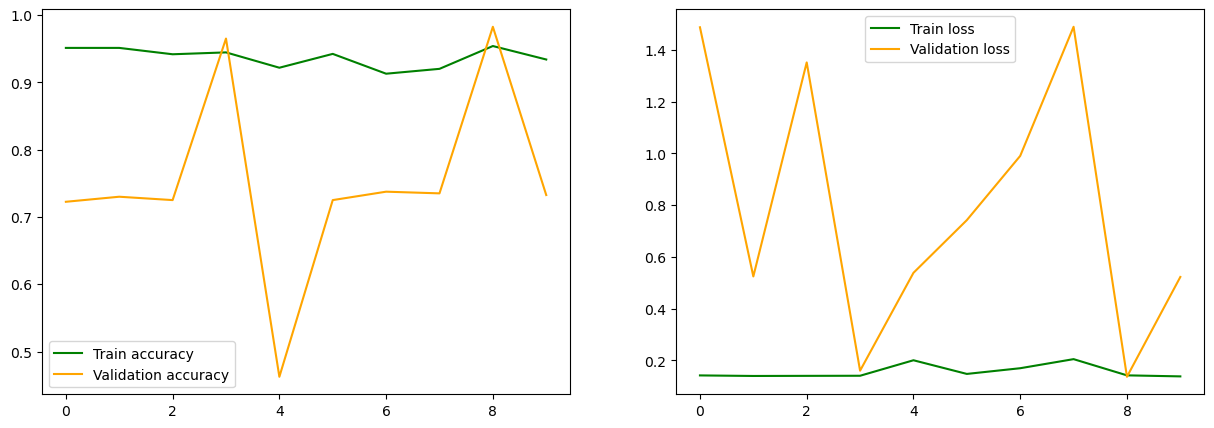

In [109]:
# ephos = 10; batch_size = 200; learning_rate = 0.006
train_loop(10, 200, 0.006)

Epoch : 1, train accuracy : 0.957160472869873, train loss : 0.12616607546806335
Epoch : 1, val_accuracy : 0.9900990128517151, val_loss : 0.0817866101861
Epoch : 2, train accuracy : 0.9674691557884216, train loss : 0.08303878456354141
Epoch : 2, val_accuracy : 0.9603960514068604, val_loss : 0.11628483235836029
Epoch : 3, train accuracy : 0.9693827033042908, train loss : 0.08032463490962982
Epoch : 3, val_accuracy : 0.9653465151786804, val_loss : 0.12181561440229416
Epoch : 4, train accuracy : 0.9631481170654297, train loss : 0.10941293090581894
Epoch : 4, val_accuracy : 0.9702970385551453, val_loss : 0.07834956794977188
Epoch : 5, train accuracy : 0.9616049528121948, train loss : 0.08853070437908173
Epoch : 5, val_accuracy : 0.9554455280303955, val_loss : 0.1074729785323143
Epoch : 6, train accuracy : 0.9706790447235107, train loss : 0.08281882107257843
Epoch : 6, val_accuracy : 0.9702970385551453, val_loss : 0.08922859281301498
Epoch : 7, train accuracy : 0.9680864214897156, train loss

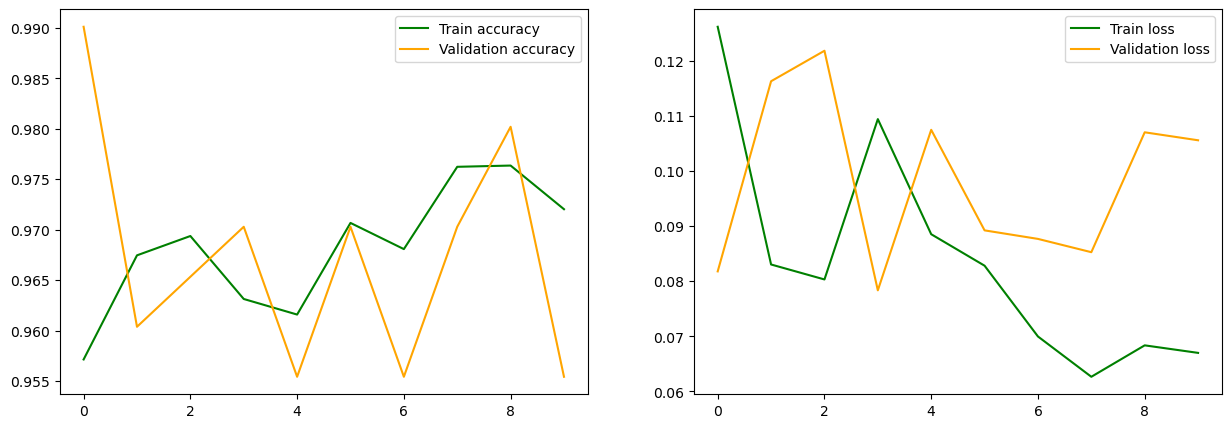

In [110]:
# ephos = 10; batch_size = 300; learning_rate = 0.006
train_loop(10, 300, 0.006)

Создаем csv файл с результатами

In [111]:
rose_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=100, shuffle=False
)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = functional.softmax(preds, dim=1)[:, 1].tolist()
        rose_probs += list(zip(list(fileid), preds_list))
rose_probs.sort(key=lambda x: int(x[0]))

rose_probs[0:5]

[(tensor(0), 0.0012554802233353257),
 (tensor(0), 1.2975956309446701e-08),
 (tensor(0), 0.018158767372369766),
 (tensor(0), 9.975956345442683e-06),
 (tensor(0), 2.7510493964655325e-05)]

In [112]:
idx = list(map(lambda x: x[0],rose_probs))
prob = list(map(lambda x: x[1],rose_probs))

Делаем csv файл

In [113]:
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)
submission

,id,label
0,tensor(0),1.255480e-03
1,tensor(0),1.297596e-08
2,tensor(0),1.815877e-02
3,tensor(0),9.975956e-06
4,tensor(0),2.751049e-05
...,...,...
196,tensor(1),9.990664e-01
197,tensor(1),9.985176e-01
198,tensor(1),9.998136e-01
199,tensor(1),9.999081e-01


Сохраняем модель

In [114]:
name_model = "model.pt"
torch.save(model.state_dict(), os.path.join("C:/Users/boris/Desktop/unik/python_university_laba/Lab5", name_model))

Повторно инициализируем модель

In [115]:
re_model = CNN()
re_model.load_state_dict(torch.load(os.path.join("C:/Users/boris/Desktop/unik/python_university_laba/Lab5", name_model)))

<All keys matched successfully>

Проверяем модель на работоспособность 

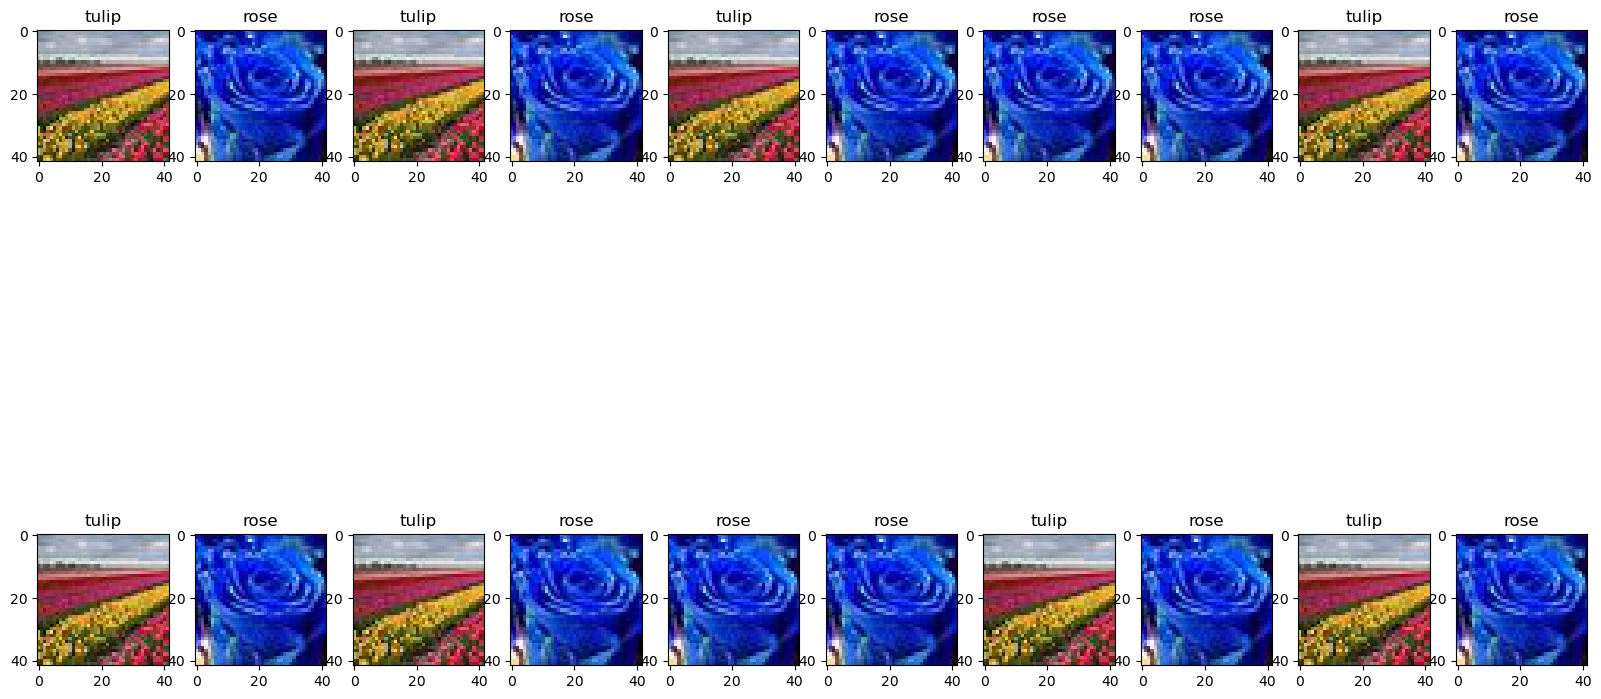

In [153]:
id_list = []
class_ = {0: 'rose', 1: 'tulip'}

fig, axes = plt.subplots(2, 10, figsize=(20, 12), facecolor='white')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = train_list[i]
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)